In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scs
import scipy.special as ssp
import statistics as stat
from operator import add
from matplotlib import gridspec
from collections import OrderedDict
from labellines import labelLines
import random

In [2]:
nLat = 1024
nTime = 256
nSims = 4000

nu = 2.*10**(-3)
omega = 0.25 * 50. * 2. * np.sqrt(nu)
delt = np.sqrt(nu / 2.) * (1. + 0.4)
rho = 200. * 2. * np.sqrt(nu) / 2.**3
lamb = delt * np.sqrt(2. / nu)
lenLat = 0.5 * 50. / np.sqrt(2. * nu); print(lenLat)

m2eff = 4. * nu * (- 1. + lamb**2); print(m2eff)
alpha = 8.
nCols = 4
n_cross = 2
phi0 = 1
sigma = 0.1/np.sqrt(m2eff); print(sigma)

############################################################
nyq = int(nLat/2)+1
hLat = int(nLat/2)
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
outsize = 4*n_cross*nLat/nTime
dtout = dt*outsize
paper_norm = 1./ phi0 / np.sqrt(2*lenLat)

395.28470752104744
0.007679999999999992
1.1410886614690967


In [3]:
#recombination_time = [time for time in range(nTime) if time%(1/(dtout*np.sqrt(m2eff)))==0]
titles = [r'Field $\phi(x)$', r'$\partial_t \phi(x)$', r'Smoothened $\phi(x)$', r'Smoothened $\partial_t \phi(x)$']
fft_titles = [r'Field $\phi(k)$', r'FT of $\partial_t \phi(x)$', r'Smoothened $\phi(k)$', r'Smoothened FT of $\partial_t \phi(x)$']
correl_plots = '/home/dpirvu/free_field_correlations/plots/'
field_plots = '/home/dpirvu/free_field_correlations/plots/'
plot_sim_suffix = '_for_t'+str(nTime)+'_x'+str(nLat)+'_fields'
plot_fft_sim_suffix = '_for_t'+str(nTime)+'_x'+str(nLat)+'_fft_fields'

## Extract data from files

In [4]:
def extract_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    field_values = [float(line.split()[col]) for line in lines[2:]]
    infile.close()
    return field_values

def complex_converter(txt):
    ii, jj = np.safe_eval(txt)
    return np.complex(ii, jj)

def extract_fft_data(filename, col):
    infile = open(filename,'r')
    lines = infile.readlines()
    str_values = [line.split()[col] for line in lines[2:]]
    complex_values = [complex_converter(str_values[i]) for i in range(len(str_values))]
    infile.close()
    return complex_values
    
def sim_location(sim):
    """ sim = simulation number """
    return '/gpfs/dpirvu/free_field_correlations/t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields.dat'

def sim_suffix(sim):
    return '_for_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fields'

def fft_sim_location(sim):
    """ sim = simulation number """
    return '/gpfs/dpirvu/free_field_correlations/t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fft_fields.dat'

def fft_sim_suffix(sim):
    return '_for_t'+str(nTime)+'_x'+str(nLat)+'_sim'+str(sim)+'_fft_fields'

def all_real_space_data():
    all_rsp_data = []
    for sim in range(nSims):
        sims_tableau = []
        for col in range(nCols-1):
            if col == 1:
                simulation = None
            else:
                simulation = extract_data(sim_location(sim), col)
                simulation = np.reshape(simulation,(nTime, nLat))
            sims_tableau.append(simulation)
        all_rsp_data.append(sims_tableau)
#    print('Data format: ', np.shape(all_rsp_data),' and corresponds to: [simulation, variable, time slice, amplitude]')
    return(all_rsp_data)

#####################################################################
# Careful whether I am considering the 0th mode!
def all_spectral_space_data():
    all_ssp_data = []
    for sim in range(nSims):
        sims_tableau = []
        for col in range(nCols-1):
            if col == 1:
                simulation = None
            else:
                simulation = extract_fft_data(fft_sim_location(sim), col)
                simulation = np.reshape(simulation, (nTime, nyq))
#                simulation = simulation[0:nTime, 1:nyq]
            sims_tableau.append(simulation)
        all_ssp_data.append(sims_tableau)
#    print('Data format: ', np.shape(all_ssp_data),' and corresponds to: [simulation, variable, frequency, amplitude]')
    return(all_ssp_data)

In [5]:
all_real_space = all_real_space_data()

In [6]:
#all_spectral_space = all_spectral_space_data()

In [7]:
timeslice = random.randrange(nTime); spaceslice = random.randrange(nLat)
field_values = [all_real_space[sim][0][timeslice][spaceslice] for sim in range(nSims)]
sm_field_values = [all_real_space[sim][2][timeslice][spaceslice] for sim in range(nSims)]
data_std = stat.stdev(field_values); data_sm_std = stat.stdev(sm_field_values)

## VISUALISING SIMULATION DATA

In [8]:
def plot_real_space_data(col, random_selection):
    fig, ax = plt.subplots(1, random_selection, figsize = (5 * random_selection, 4), sharey = 'row')
    fig.suptitle(titles[col], fontsize=22)
    fig.subplots_adjust(top=0.8)
    ii = 0
    for simulation in range(random_selection):
        sim = random.randrange(nSims)
        tableau = all_real_space[sim][col]
        im = ax[ii].imshow(tableau, aspect='auto', interpolation='none', origin='lower')
        plt.colorbar(im, ax = ax[ii])
        ax[ii].set(xlabel = r'$dx$', ylabel = r'$dt$')
        ax[ii].set_title('Simulation ' + str(sim + 1))
        ii = ii + 1
    plt.savefig(field_plots + '_col' + str(col) + plot_sim_suffix + '.png')
    return

In [9]:
#plot_real_space_data(0, 3)
#plot_real_space_data(2, 3)

In [10]:
def plot_spectral_space_data(col, random_selection):
    fig,ax = plt.subplots(1, random_selection, figsize=(5*random_selection, 4), sharey = 'row')
    fig.suptitle(fft_titles[col], fontsize=22)
    fig.subplots_adjust(top=0.8)
    ii = 0
    for simulation in range(random_selection):
        sim = random.randrange(nSims)
        tableau = all_spectral_space[sim][col]
        pspec = [[abs(i*np.conj(i)) for i in tableau[j]] for j in range(nTime)]
        im = ax[ii].imshow(pspec, aspect = 'auto', interpolation = 'none', origin = 'lower')
        plt.colorbar(im, ax = ax[ii])
        ax[ii].set(xlabel = r'$dk$', ylabel = r'$dt$')
        ax[ii].set_title('Simulation ' + str(sim + 1))
        ii = ii + 1
    plt.savefig(field_plots + '_col' + str(col) + plot_fft_sim_suffix + '.png')
    return

In [11]:
#plot_spectral_space_data(0, 3)
#plot_spectral_space_data(2, 3)

In [12]:
def plot_real_space_slices(col, sim, i, j, steps):
    plt.figure(figsize=(5,5))
    tableau = all_real_space[sim][col][0:nTime] * 2**0.5 / nLat
    for slice in tableau[i:j:steps]:
        plt.plot(np.arange(nLat), slice, label = i)
        i = i + steps
    labelLines(plt.gca().get_lines(), xvals=(0,hLat), align=False, fontsize=16)
    plt.xlabel(r'$dx$')
    plt.ylabel(titles[col])
    plt.title('Simulation '+str(sim+1))
    plt.grid()
    plt.savefig(field_plots+'slices_i'+str(i)+'_to_j'+str(j)+'_every_t'+str(steps)+'_col'+str(col)+plot_sim_suffix+'.png')
    return

In [13]:
#plot_real_space_slices(2, 0, 0, nTime, 100)

In [14]:
def plot_spectral_space_slices(col, sim, i, j, steps):
    plt.figure(figsize=(5,5))
    tableau = all_spectral_space[sim][col] * 2**0.5 / nLat
    pspec = [[abs(i*np.conj(i)) for i in tableau[j]] for j in range(nTime)]
    for slice in tableau[i:j:steps]:
        plt.plot(np.arange(nyq), slice, label = i)
        i = i + steps
    labelLines(plt.gca().get_lines(), xvals=(0, nyq-1), align=False, fontsize=16)
    plt.xlabel(r'$dk$')
    plt.ylabel(fft_titles[col])
    plt.title('Simulation '+str(sim+1))
    plt.grid()
    plt.savefig(field_plots+'slices_i'+str(i)+'_to_j'+str(j)+'_every_t'+str(steps)+'_col'+str(col)+plot_fft_sim_suffix+'.png')
    return

In [15]:
#plot_spectral_space_slices(0, 0, 0, nTime, 100)
#plot_spectral_space_slices(2, 0, 0, nTime, 100)

In [16]:
def add_mask(col, threshold, sim):
    masked_field = []
    mask = np.zeros((nTime, nLat))
    smoothened_field = all_real_space[sim][col] #open tableau of field values for each simulation
    for i in range(nLat):
        for j in range(nTime):
            if smoothened_field[j,i] > threshold:
                mask[j,i] = 1
    return(smoothened_field * mask)

In [17]:
def plot_masked_field(col, threshold, random_selection):
    fig, ax = plt.subplots(1, random_selection, figsize = (5 * random_selection, 4), sharey = 'row')
    fig.suptitle(r'Masked '+titles[col], fontsize=22)
    fig.subplots_adjust(top=0.8)
    ii = 0
    for simulation in range(random_selection):
        sim = random.randrange(nSims)
        masked_field = add_mask(col, threshold, sim)
        im = ax[ii].imshow(masked_field, aspect='auto', interpolation='none', origin='lower')
        plt.colorbar(im, ax = ax[ii])
        ax[ii].set(xlabel = r'$dx$',ylabel=r'$dt$')
        ax[ii].set_title('Simulation ' + str(sim+1))
        ii = ii + 1
    plt.savefig(field_plots + 'plot_masked_field' + '_col' + str(col) + plot_sim_suffix + '.png')
    return

In [18]:
#plot_masked_field(0, 0.5, 3)
#plot_masked_field(2, 0.5, 3)

In [19]:
def plot_masked_slices(col, sim, threshold, i, j, steps):
    plt.figure(figsize=(5,5))
    masked_field = add_mask(col, threshold, sim)
    for slice in masked_field[i:j:steps]:
        plt.plot(np.arange(nLat), slice, label = i)
        i = i + steps
    labelLines(plt.gca().get_lines(), xvals=(0,hLat), align=False, fontsize=16)
    plt.xlabel(r'$dx$')
    plt.ylabel(titles[col])
    plt.ylim(bottom = threshold)
    plt.title('Simulation '+str(sim+1))
    plt.grid()
    plt.savefig(field_plots+'plot_masked_slices_i'+str(i)+'_to_j'+str(j)+'_every_t'+str(steps)+'_col'+str(col)+plot_sim_suffix+'.png')
    return

In [20]:
#plot_masked_slices(0, 0, data_std, 0, nTime, 50)
#plot_masked_slices(2, 0, data_sm_std, 0, nTime, 50)

## Analytical Power Spectrum

In [21]:
def omega_k(k):
    return ((dk*k)**2 + m2eff)**(0.5)

paper_norm = 1./ phi0 / np.sqrt(2*lenLat)
def spectral_scalar_field(k):
    return paper_norm / np.sqrt(omega_k(k))

window_gauss = [np.exp(- 0.5 * (dk*k*sigma)**2) for k in range(nyq)]
def window_gaussian(k):
    return window_gauss[k]
# should check the other notebook for compatibility with fortran filter

def spectral_smoothed_field(k):
    return window_gaussian(k) * spectral_scalar_field(k)

def pspec(k):
    pspec = spectral_scalar_field(k) * np.conj(spectral_scalar_field(k))
    return pspec.real

def smoothened_pspec(k):
    pspec = spectral_smoothed_field(k) * np.conj(spectral_smoothed_field(k))
    return pspec.real

## Correlators from Theoretical Power Spectrum

In [22]:
#Taking Fourier transform of the theoretical curve above wrt space
def space_fft_th_pspec(R):
    """The sum of terms in the discrete fft of theoretical k_space power spectrum."""
    terms = [pspec(k) * np.cos(dk*k*dx*R) for k in range(1, nyq)]
    return sum(terms)

#And for the smoothened curve
def space_fft_sm_th_pspec(R):
    """The sum of terms in the discrete fft of theoretical k_space power spectrum."""
    terms = [smoothened_pspec(k) * np.cos(dk*k*dx*R) for k in range(1, nyq)]
    return sum(terms)

#Taking Fourier transform of the theoretical curve above wrt space
def time_fft_th_pspec(t):
    """The sum of terms in the discrete fft of theoretical k_space power spectrum."""
    terms = [pspec(k) * np.cos(omega_k(k)*dtout*t) for k in range(1, nyq)]
    return sum(terms)

#Smoothened
def time_fft_sm_th_pspec(t):
    """The sum of terms in the discrete fft of theoretical k_space power spectrum."""
    terms = [smoothened_pspec(k) * np.cos(omega_k(k)*dtout*t) for k in range(1, nyq)]
    return sum(terms)

In [23]:
def th_spacelike_correlator():
    plt.figure(figsize=(7,5))
    plt.plot(dx*np.arange(1, hLat+1), [space_fft_th_pspec(R) for R in range(hLat)], 'b', label=r'$P(k)$')
    plt.plot(dx*np.arange(1, hLat+1), [space_fft_sm_th_pspec(R) for R in range(hLat)], 'r', label=r'$P_{sm}(k)$')
    plt.xlabel(r'$r = |x-y|$')
    plt.ylabel(r'$<\phi(x,t)\phi(y,t)>$')
    plt.suptitle(r'Theoretical spacelike correlator', fontsize=21)
    plt.grid()
    plt.legend()
#    plt.savefig(plots_file +'th_spacelike_correlator'+plot_sim_suffix+'.png')
    plt.show()
    return

def th_timelike_correlator():
    plt.figure(figsize=(7,5))
    plt.plot(dtout*np.arange(1, nTime+1),[time_fft_th_pspec(t) for t in range(nTime)],'b', label=r'$P(k)$')
    plt.plot(dtout*np.arange(1, nTime+1),[time_fft_sm_th_pspec(t) for t in range(nTime)],'r', label=r'$P_{sm}(k)$')
    plt.xlabel(r'$t_1-t_2$')
    plt.ylabel(r'$<\phi(x,t_1)\phi(x,t_2)>$')
    plt.suptitle(r'Theoretical timelike correlator')
    plt.grid()
    plt.legend()
#    plt.savefig(plots_file+'th_timelike_correlator'+plot_sim_suffix+'.png')
    plt.show()
    return

## Correlator from Simulation Data

In [24]:
# Power spectrum from simulation
def data_pspec(col, sim, k):
    """ This is the P(k)=P(-k) from simulation data for k = 0,1,...,nLat/2"""
    timeslice = random.randrange(nTime)
    spec_field = all_spectral_space[sim][col][timeslice]
    return spec_field[k] * np.conj(spec_field[k]) * 2 / nLat**2 # some normalisation not present in simulation: nLat for the FT convention, and the 2 from the BM

#Average power specturm over simulations
def data_pspec_sim_averaged(col, k):
    return np.mean([data_pspec(col, sim, k) for sim in range(nSims)])

In [25]:
def power_spectrum_theoretical_vs_data():
    plt.figure(figsize=(7, 7))
    plt.plot(np.arange(1, nyq), [data_pspec_sim_averaged(0, k) for k in range(1, nyq)], 'bo', label=r'$P(k)_{data}$')
    plt.plot(np.arange(1, nyq), [pspec(k) for k in range(1, nyq)], 'r--', label=r'$P(k)_{th}$')
    plt.plot(np.arange(1, nyq), [data_pspec_sim_averaged(2, k) for k in range(1, nyq)], 'go', label=r'Smooth $P(k)_{data}$')
    plt.plot(np.arange(1, nyq), [smoothened_pspec(k) for k in range(1, nyq)], color='orange', ls='--', label=r'Smooth $P(k)_{th}$')
    plt.grid(); plt.legend()
    plt.savefig(correl_plots + 'power_spectrum_theoretical_vs_data'+plot_sim_suffix+'.png')
    plt.show()
    return

In [26]:
#power_spectrum_theoretical_vs_data()

## Two-point correlation from real space data

In [27]:
#Spacelike correlator from simulation real space data '_fields.dat'
def space_difference_amplitude(col, sim, R):
    timeslice = random.randrange(nTime)
    x = random.randrange(nLat)
    field = all_real_space[sim][col][timeslice]
    a = x + R
    b = x - R

    if a >= nLat:
        a = a - nLat
    if b < 0:
        b = b + nLat
    return 0.5*(field[x] * field[a] + field[x] * field[b])

#Average over simulations at fixed separation R
def sim_average_of_space_difference_amp(col, R):
    return np.mean([space_difference_amplitude(col, sim, R) for sim in range(nSims)])

#Timelike correlator from simulation real space data '_fields.dat'
def time_difference_amplitude(col, sim, deltat):
    spaceslice = random.randrange(nLat)
    T = random.randrange(nTime-deltat)
    time_field = [all_real_space[sim][col][i][spaceslice] for i in range(nTime)]
    a = T + deltat
    b = T - deltat

    if a < nTime and b >= 0:
        x = 0.5 * (time_field[T] * time_field[a] + time_field[T] * time_field[b])
    elif a < nTime and b < 0:
        x = time_field[T] * time_field[a]
    elif a >= nTime and b >= 0:
        x = time_field[T] * time_field[b]
    return x

#Average over simulations at fixed time separation deltat
def sim_average_of_time_difference_amp(col, deltat):
    return np.mean([time_difference_amplitude(col, sim, deltat) for sim in range(nSims)])

In [28]:
#Spacelike correlator from simulation spectral space data (power spectrum) '_fft_fields.dat'
def pspec_fft_spacelike(col, sim, R):
    """The sum of terms in the discrete fft from k_space power spectrum to x_space autocorrelation function at separation R."""
    terms = [data_pspec(col, sim, k)*np.cos(dk*k*dx*R) for k in range(1, nyq)]
    return np.sum(terms)

#Average over simulations for fixed separation R
def pspec_fft_space_sim_averaged(col, R):
    return np.mean([pspec_fft_spacelike(col, sim, deltat) for sim in range(nSims)])

#Timelike correlator from simulation spectral space data (power spectrum '_fft_fields.dat'
def pspec_fft_timelike(col, sim, deltat):
    """The sum of terms in the discrete fft from k_space pspec to time-time autocorrelation function at separation \Delta t."""
    terms = [data_pspec(col, sim, k) * np.cos(omega_k(k)*deltat*dtout) for k in range(1, nyq)]
#    terms = [data_pspec(col, sim, k) * np.cos(deltat*dtout*2 / nLat**2 /data_pspec(col, sim, k)) for k in range(1, nyq)]
    return np.sum(terms)

#Average over simulations at fixed time separation deltat
def pspec_fft_time_sim_averaged(col, deltat):
    return np.mean([pspec_fft_timelike(col, sim, deltat) for sim in range(nSims)])

## Plotting Correlation Functions

In [41]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

def plot_spacelike_correlator(max):
    """Plots autocorrelation function at all distances, averaged in time."""
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 5]) 
    ax0 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    plt.subplots_adjust(wspace=.2)
    ax0.grid()
    ax2.grid()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

#    yticks2 = ax2.yaxis.get_major_ticks()
#    yticks3 = ax3.yaxis.get_major_ticks()
#    yticks2[-1].label1.set_visible(False)
#    yticks3[-1].label1.set_visible(False)

    ax0.set_ylabel(r'$\left< \phi(x^0=0, x^1) \phi(y^0=0, y^1) \right>$')
    ax0.set_xlabel(r'$r = |x^1-y^1|$')
    ax2.set_xlabel(r'$r = |x^1-y^1|$')

    rspec_data = [sim_average_of_space_difference_amp(0, R) for R in range(max)]
    ax0.plot([i*dx for i in range(1, max+1)], rspec_data[0:max], 'bo')

    rspec_data_sm = [sim_average_of_space_difference_amp(2, R) for R in range(max)]
    ax2.plot([i*dx for i in range(1, max+1)], rspec_data_sm[0:max], 'bo')

#    pspec_data = [pspec_fft_space_sim_averaged(col, R).real for R in range(max)]
#    ax0.plot([i*dx for i in range(1, max+1)], pspec_data[0:max], 'go')
#    ax2.plot([i*dx for i in range(1, max+1)], [pspec_data[i]-th[i] for i in range(max)], 'g--')

    th = [space_fft_th_pspec(R) for R in range(max)]
    ax0.plot([i*dx for i in range(1, max+1)], th[0:max],'r--')
    
    th_sm = [space_fft_sm_th_pspec(R) for R in range(max)]
    ax2.plot([i*dx for i in range(1, max+1)], th_sm[0:max],'r--')
    
    plt.savefig(correl_plots+'spacelike'+plot_sim_suffix+'.png')
    plt.show()
    return

def plot_timelike_correlator():
    """Plots autocorrelation function at all time intervals, averaged over lattice and simulations."""
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, 5]) 
    ax0 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    plt.subplots_adjust(wspace=.2)
    ax0.grid()
    ax2.grid()
    
    ax0.set_ylabel(r'$\left< \phi(t, x^1=x) \phi(t^{\prime}, y^1=x) \right>$')
    ax0.set_xlabel(r'$\Delta t = |t-t^{\prime}|$')
    ax2.set_xlabel(r'$\Delta t = |t-t^{\prime}|$')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

#    pspec_data = [pspec_fft_time_sim_averaged(col, deltat).real for deltat in range(nTime-1)]
#    ax0.plot([i*dtout for i in range(nTime-1)], pspec_data, 'go')
#    ax2.plot([i*dtout for i in range(nTime-1)], [pspec_data[i]-th[i] for i in range(len(pspec_data))], 'g--')


    rspec_data = [sim_average_of_time_difference_amp(0, deltat) for deltat in range(nTime-1)]
    ax0.plot([i*dtout for i in range(nTime-1)], rspec_data, 'go')
    rspec_data_sm = [sim_average_of_time_difference_amp(2, deltat) for deltat in range(nTime-1)]
    ax2.plot([i*dtout for i in range(nTime-1)], rspec_data_sm, 'go')

    th = [time_fft_th_pspec(deltat) for deltat in range(nTime-1)]
    ax0.plot([i*dtout for i in range(nTime-1)], th, 'r--')
    th_sm = [time_fft_sm_th_pspec(deltat) for deltat in range(nTime-1)]
    ax2.plot([i*dtout for i in range(nTime-1)], th_sm, 'r--')

    plt.savefig(correl_plots+'timelike'+plot_sim_suffix+'.png')
    plt.show()
    return

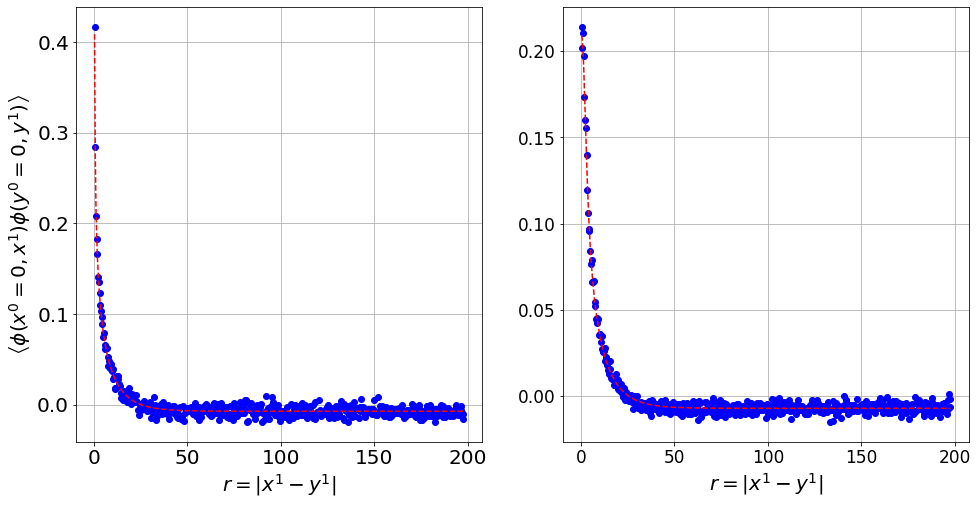

In [42]:
plot_spacelike_correlator(512)

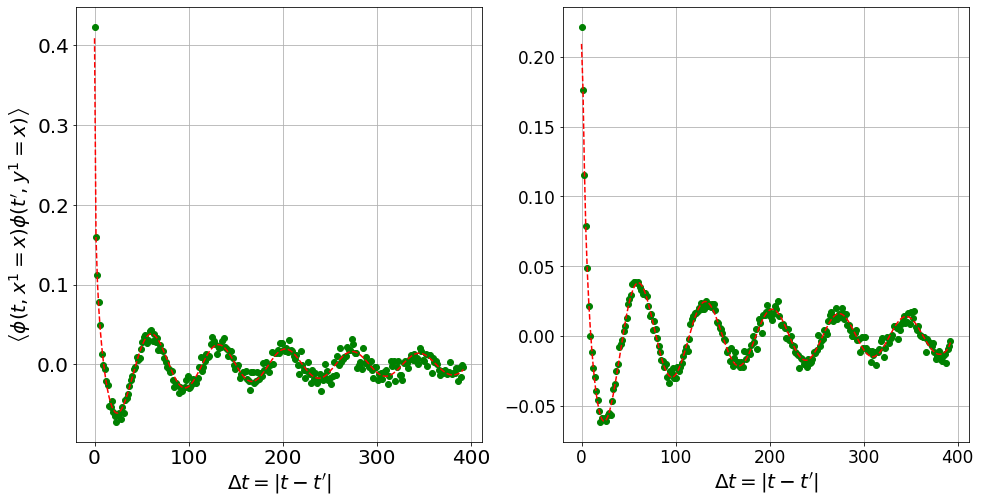

In [43]:
plot_timelike_correlator()

In [44]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

def plot_spacelike_correlator(max):
    """Plots autocorrelation function at all distances, averaged in time."""
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[4, 1], width_ratios=[5, 5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3], sharex = ax2)
    
    plt.setp(ax0.get_xticklabels(), visible = False)
#    plt.setp(ax1.get_yticklabels(), visible = False)
    plt.setp(ax1.get_xticklabels(), visible = False)
#    plt.setp(ax3.get_yticklabels(), visible = False)
    plt.subplots_adjust(wspace=.2)
    plt.subplots_adjust(hspace=.0)
    ax0.grid()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

#    yticks2 = ax2.yaxis.get_major_ticks()
#    yticks3 = ax3.yaxis.get_major_ticks()
#    yticks2[-1].label1.set_visible(False)
#    yticks3[-1].label1.set_visible(False)

    ax0.set_ylabel(r'$\left< \phi(x^0=0, x^1) \phi(y^0=0, y^1) \right>$')
    ax2.set_xlabel(r'$r = |x^1-y^1|$')
    ax3.set_xlabel(r'$r = |x^1-y^1|$')

    rspec_data = [sim_average_of_space_difference_amp(0, R) for R in range(max)]
    ax0.plot([i*dx for i in range(1, max+1)], rspec_data[0:max], 'bo')

    rspec_data_sm = [sim_average_of_space_difference_amp(2, R) for R in range(max)]
    ax1.plot([i*dx for i in range(1, max+1)], rspec_data_sm[0:max], 'bo')

#    pspec_data = [pspec_fft_space_sim_averaged(col, R).real for R in range(max)]
#    ax0.plot([i*dx for i in range(1, max+1)], pspec_data[0:max], 'go')
#    ax2.plot([i*dx for i in range(1, max+1)], [pspec_data[i]-th[i] for i in range(max)], 'g--')

    th = [space_fft_th_pspec(R) for R in range(max)]
    ax0.plot([i*dx for i in range(1, max+1)], th[0:max],'r--')
    
    th_sm = [space_fft_sm_th_pspec(R) for R in range(max)]
    ax1.plot([i*dx for i in range(1, max+1)], th_sm[0:max],'r--')
    
    ax2.plot([i*dx for i in range(1, max+1)], [rspec_data[i]-th[i] for i in range(max)], 'b--')
    ax3.plot([i*dx for i in range(1, max+1)], [rspec_data_sm[i]-th_sm[i] for i in range(max)], 'b--')

    plt.savefig(correl_plots+'spacelike'+plot_sim_suffix+'.png')
    plt.show()
    return

def plot_timelike_correlator():
    """Plots autocorrelation function at all time intervals, averaged over lattice and simulations."""
    fig = plt.figure(figsize=(16,8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[4, 1], width_ratios=[5, 5]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3], sharex = ax2)
    
    plt.setp(ax0.get_xticklabels(), visible = False)
#    plt.setp(ax1.get_yticklabels(), visible = False)
    plt.setp(ax1.get_xticklabels(), visible = False)
#    plt.setp(ax3.get_yticklabels(), visible = False)
    plt.subplots_adjust(wspace=.2)
    plt.subplots_adjust(hspace=.0)
    ax0.grid()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    
#    yticks2 = ax2.yaxis.get_major_ticks()
#    yticks3 = ax3.yaxis.get_major_ticks()
#    yticks2[-1].label1.set_visible(False)
#    yticks3[-1].label1.set_visible(False)

    ax0.set_ylabel(r'$\left< \phi(t, x^1=x) \phi(t^{\prime}, y^1=x) \right>$')
    ax2.set_xlabel(r'$\Delta t = |t-t^{\prime}|$')
    ax3.set_xlabel(r'$\Delta t = |t-t^{\prime}|$')

#    pspec_data = [pspec_fft_time_sim_averaged(col, deltat).real for deltat in range(nTime-1)]
#    ax0.plot([i*dtout for i in range(nTime-1)], pspec_data, 'go')
#    ax2.plot([i*dtout for i in range(nTime-1)], [pspec_data[i]-th[i] for i in range(len(pspec_data))], 'g--')


    rspec_data = [sim_average_of_time_difference_amp(0, deltat) for deltat in range(nTime-1)]
    ax0.plot([i*dtout for i in range(nTime-1)], rspec_data, 'go')
    rspec_data_sm = [sim_average_of_time_difference_amp(2, deltat) for deltat in range(nTime-1)]
    ax1.plot([i*dtout for i in range(nTime-1)], rspec_data_sm, 'go')

    th = [time_fft_th_pspec(deltat) for deltat in range(nTime-1)]
    ax0.plot([i*dtout for i in range(nTime-1)], th, 'r--')
    th_sm = [time_fft_sm_th_pspec(deltat) for deltat in range(nTime-1)]
    ax1.plot([i*dtout for i in range(nTime-1)], th_sm, 'r--')

    ax2.plot([i*dtout for i in range(nTime-1)], [rspec_data[i]-th[i] for i in range(len(rspec_data))], 'g--')
    ax3.plot([i*dtout for i in range(nTime-1)], [rspec_data_sm[i]-th_sm[i] for i in range(len(rspec_data_sm))], 'g--')

    plt.savefig(correl_plots+'timelike'+plot_sim_suffix+'.png')
    plt.show()
    return

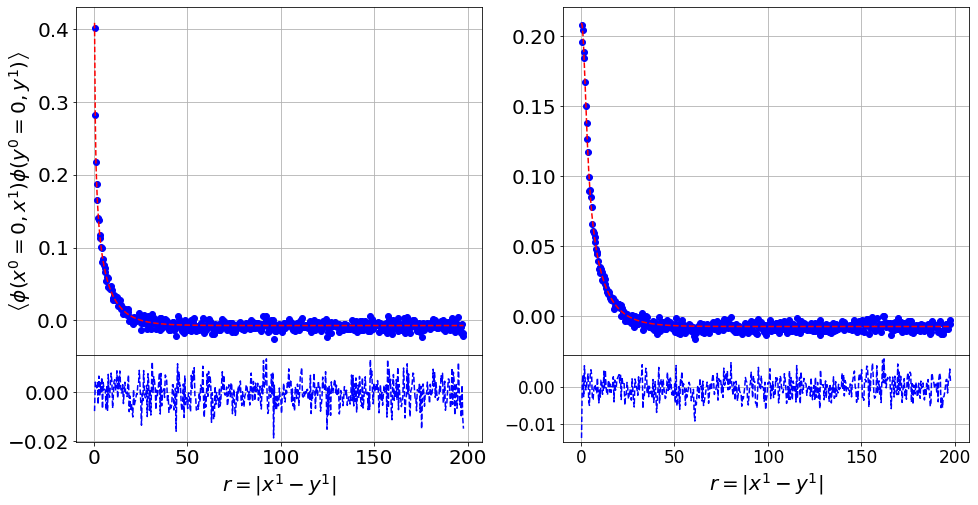

In [45]:
plot_spacelike_correlator(512)

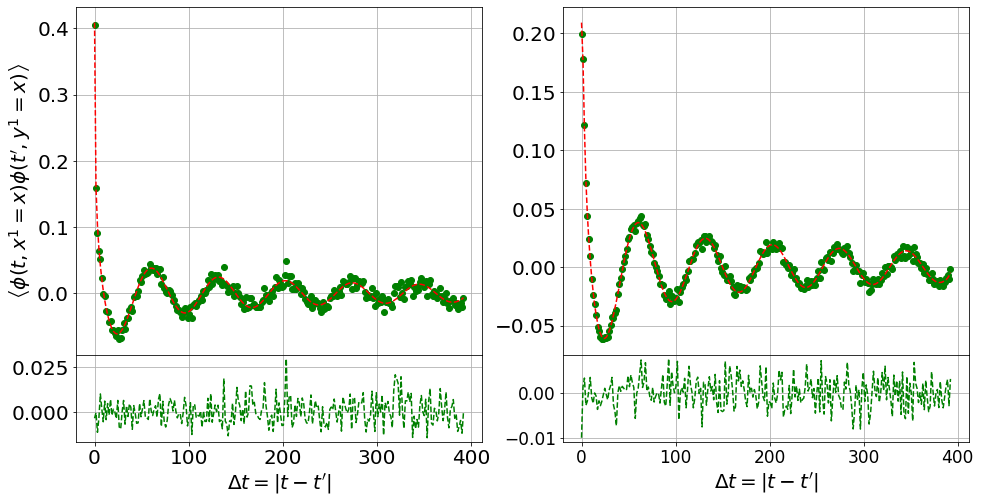

In [46]:
plot_timelike_correlator()